<a href="https://colab.research.google.com/github/drandrewwilliams/andrewbwilliamsphd/blob/master/AI4DM2Lab6%20working%204.16.2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn fairlearn aif360



In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
#from aif360.algorithms.postprocessing import CalibratedEqualizedOdds
from aif360.algorithms.inprocessing import PrejudiceRemover # Importing PrejudiceRemover instead

pip install 'aif360[inFairness]'


In [3]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")
plt.rcParams['figure.figsize'] = (12, 8)

In [4]:
# Part 1: Understanding Bias in AI

## Types of Bias in AI Systems

#AI systems can be affected by various types of bias. Let's explore the main categories:

#1. **Historical Bias**: Occurs when the data reflects past prejudices or societal inequalities
#2. **Representation Bias**: When certain groups are underrepresented in the training data
#3. **Measurement Bias**: Due to how features are defined or measured
#4. **Aggregation Bias**: When models work well for dominant groups but fail for minority groups
#5. **Evaluation Bias**: When testing/validation data or metrics don't represent real-world conditions
#6. **Deployment Bias**: Emerges from how models are implemented and used in practice

## Reflection Questions

#**Complete the following reflection questions:**

#1. How might each type of bias manifest in a project management context?
#2. What are the potential consequences of unaddressed bias in business decision-making systems?
#3. What stakeholders might be affected differently by these biases?

#*Your answers here:*

# Part 2: Bias Detection

#Let's work with the Adult Income Census dataset, which is commonly used to predict whether an individual earns more than $50,000 per year based on demographic and employment information.

## Data Loading and Exploration

In [5]:
# Load the dataset

In [6]:
from sklearn.datasets import fetch_openml

# Fetch the Adult Census Income dataset
adult = fetch_openml(name='adult', version=2, as_frame=True)
X = adult.data
y = adult.target

# Preview the data
print("Dataset shape:", X.shape)
X.head()

Dataset shape: (48842, 14)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States


In [7]:
# Examine the target variable
print("Target distribution:")
print(y.value_counts(normalize=True))

Target distribution:
class
<=50K    0.760718
>50K     0.239282
Name: proportion, dtype: float64


In [8]:
## Exploratory Data Analysis for Bias Detection

#Let's analyze the dataset's composition across key demographic attributes to identify potential sources of bias.


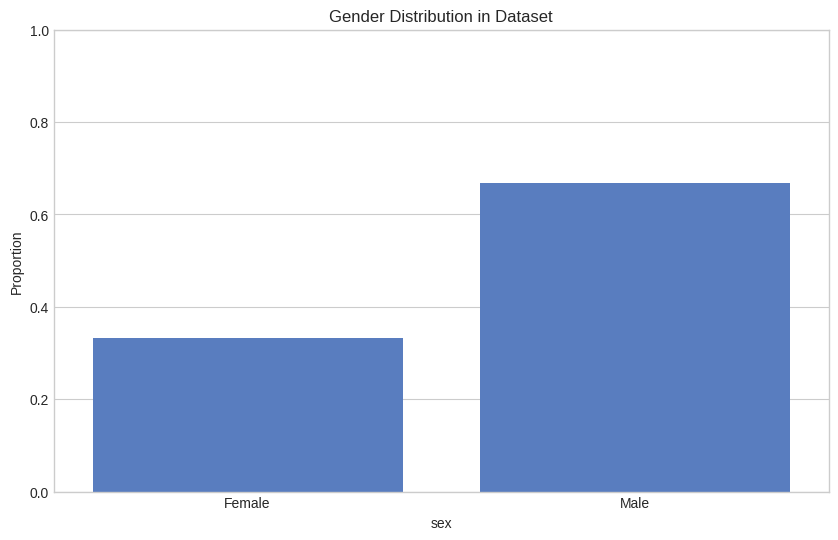

In [9]:
# Convert categorical variables to pandas category type
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category')

# Analyze gender distribution
gender_distribution = X['sex'].value_counts(normalize=True)
plt.figure(figsize=(10, 6))
sns.barplot(x=gender_distribution.index, y=gender_distribution.values)
plt.title('Gender Distribution in Dataset')
plt.ylabel('Proportion')
plt.ylim(0, 1)
plt.show()

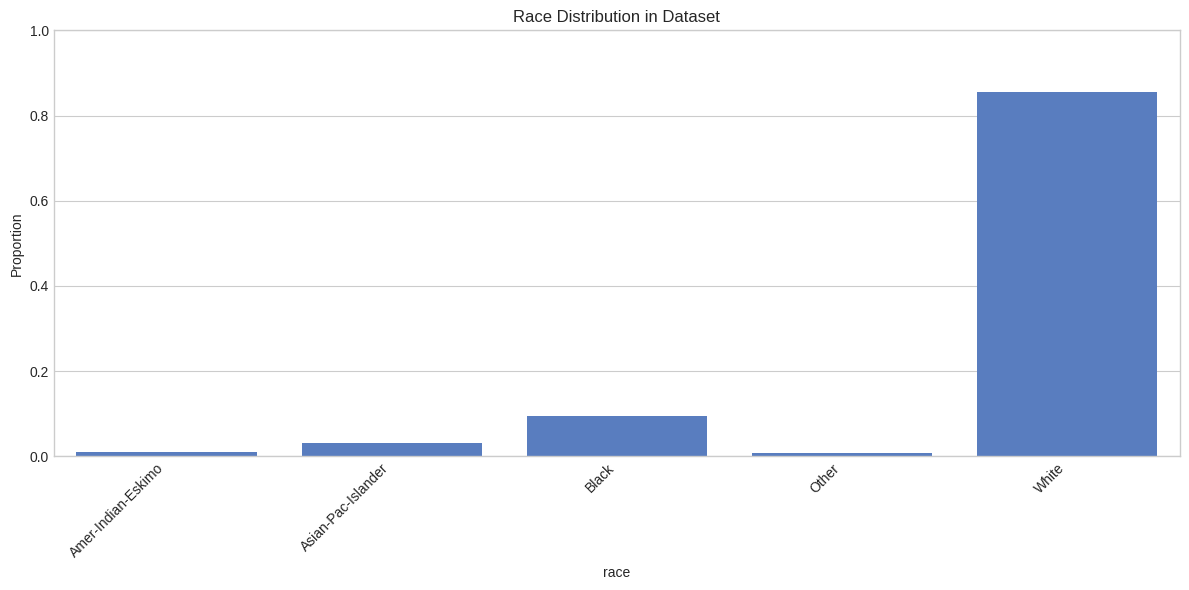

In [10]:
# Analyze race distribution
race_distribution = X['race'].value_counts(normalize=True)
plt.figure(figsize=(12, 6))
sns.barplot(x=race_distribution.index, y=race_distribution.values)
plt.title('Race Distribution in Dataset')
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

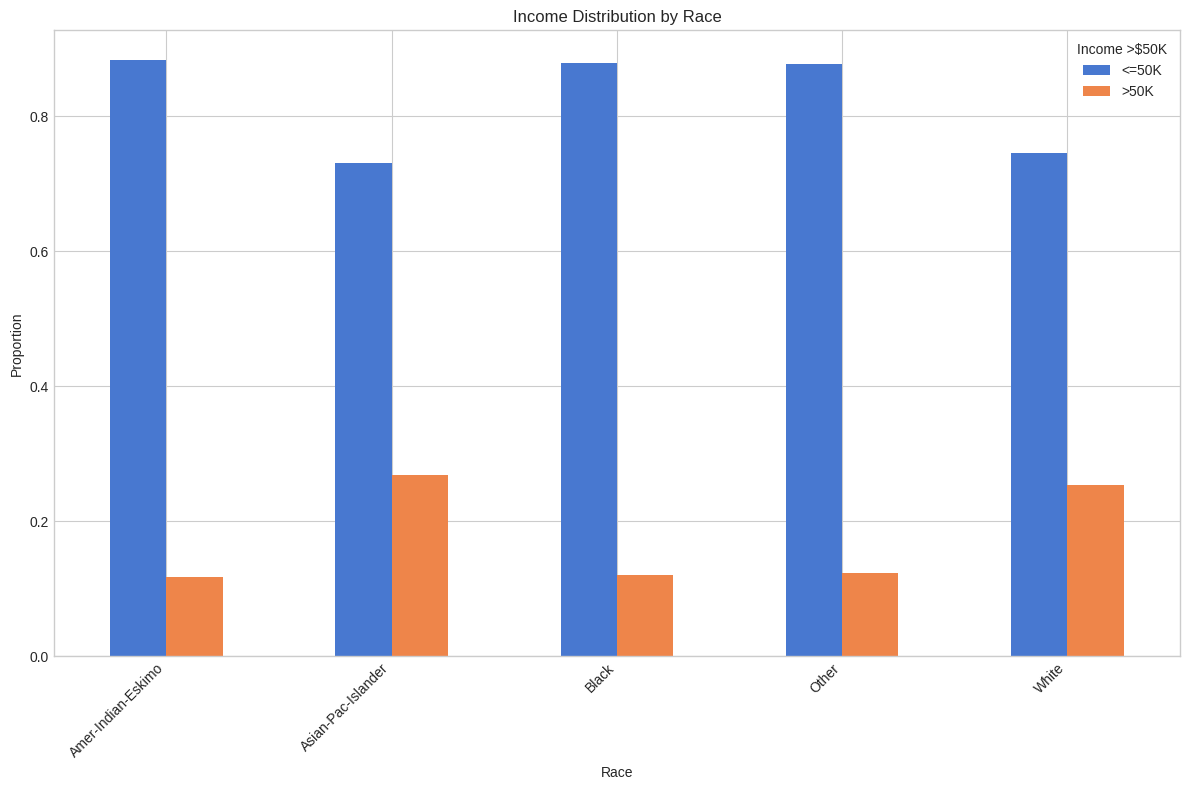

In [11]:
# Analyze the outcome distribution by race
income_by_race = pd.crosstab(X['race'], y, normalize='index')
plt.figure(figsize=(12, 6))
income_by_race.plot(kind='bar')
plt.title('Income Distribution by Race')
plt.xlabel('Race')
plt.ylabel('Proportion')
plt.legend(title='Income >$50K')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
## Calculate Representation Ratios

#Let's examine the representation of different demographic groups in the high-income category.

In [13]:
# Calculate representation ratio for gender (compared to overall population)
total_high_income = (y == '>50K').mean()
high_income_by_gender = y.groupby(X['sex']).apply(lambda x: (x == '>50K').mean())
gender_representation_ratio = high_income_by_gender / total_high_income

print("Gender representation ratio in high income group:")
print(gender_representation_ratio)

# Calculate representation ratio for race
high_income_by_race = y.groupby(X['race']).apply(lambda x: (x == '>50K').mean())
race_representation_ratio = high_income_by_race / total_high_income

print("\nRace representation ratio in high income group:")
print(race_representation_ratio)

Gender representation ratio in high income group:
sex
Female    0.456581
Male      1.269496
Name: class, dtype: float64

Race representation ratio in high income group:
race
Amer-Indian-Eskimo    0.489052
Asian-Pac-Islander    1.125268
Black                 0.504891
Other                 0.514677
White                 1.061455
Name: class, dtype: float64


<ipython-input-13-b6723e20e849>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  high_income_by_gender = y.groupby(X['sex']).apply(lambda x: (x == '>50K').mean())
<ipython-input-13-b6723e20e849>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  high_income_by_race = y.groupby(X['race']).apply(lambda x: (x == '>50K').mean())


In [14]:
## Data Preparation for Modeling


In [15]:
# Prepare the dataset for modeling
# Convert categorical features to one-hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Store sensitive attributes for fairness evaluation
gender = X['sex'] == 'Female'  # 1 for Female, 0 for Male
race = X['race'] == 'Black'    # 1 for Black, 0 for others (simplified for this exercise)

# Convert target to binary (1 for income >50K, 0 for <=50K)
y_binary = (y == '>50K').astype(int)

# Split the data
X_train, X_test, y_train, y_test, gender_train, gender_test, race_train, race_test = train_test_split(
    X_encoded, y_binary, gender, race, test_size=0.2, random_state=42
)

# Scale numerical features
scaler = StandardScaler()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [16]:
# Scale numerical features
scaler = StandardScaler()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [17]:
# Train a simple logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate overall model performance
print("Overall model accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Overall model accuracy: 0.8569966219674481

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      7479
           1       0.74      0.61      0.67      2290

    accuracy                           0.86      9769
   macro avg       0.81      0.77      0.79      9769
weighted avg       0.85      0.86      0.85      9769



In [18]:
# Evaluate performance by gender
female_idx = gender_test
male_idx = ~gender_test

print("Performance for females:")
print("Accuracy:", accuracy_score(y_test[female_idx], y_pred[female_idx]))
print("Positive prediction rate:", y_pred[female_idx].mean())

print("\nPerformance for males:")
print("Accuracy:", accuracy_score(y_test[male_idx], y_pred[male_idx]))
print("Positive prediction rate:", y_pred[male_idx].mean())

# Calculate fairness metrics
print("\nFairness Metrics:")
print("Demographic Parity Difference (Gender):",
      demographic_parity_difference(y_true=y_test,
                                   y_pred=y_pred,
                                   sensitive_features=gender_test))

Performance for females:
Accuracy: 0.9376918354818907
Positive prediction rate: 0.07305095150399017

Performance for males:
Accuracy: 0.8166180310244202
Positive prediction rate: 0.2544923974811857

Fairness Metrics:
Demographic Parity Difference (Gender): 0.18144144597719553


In [19]:
# Evaluate performance by race
black_idx = race_test
other_race_idx = ~race_test

print("Performance for Black individuals:")
print("Accuracy:", accuracy_score(y_test[black_idx], y_pred[black_idx]))
print("Positive prediction rate:", y_pred[black_idx].mean())

print("\nPerformance for other races:")
print("Accuracy:", accuracy_score(y_test[other_race_idx], y_pred[other_race_idx]))
print("Positive prediction rate:", y_pred[other_race_idx].mean())

# Calculate fairness metrics
print("\nFairness Metrics:")
print("Demographic Parity Difference (Race):",
      demographic_parity_difference(y_true=y_test,
                                   y_pred=y_pred,
                                   sensitive_features=race_test))

Performance for Black individuals:
Accuracy: 0.9223205506391348
Positive prediction rate: 0.07571288102261553

Performance for other races:
Accuracy: 0.8494058500914077
Positive prediction rate: 0.20772394881170017

Fairness Metrics:
Demographic Parity Difference (Race): 0.13201106778908464


In [20]:
## Visualize Bias in Predictions

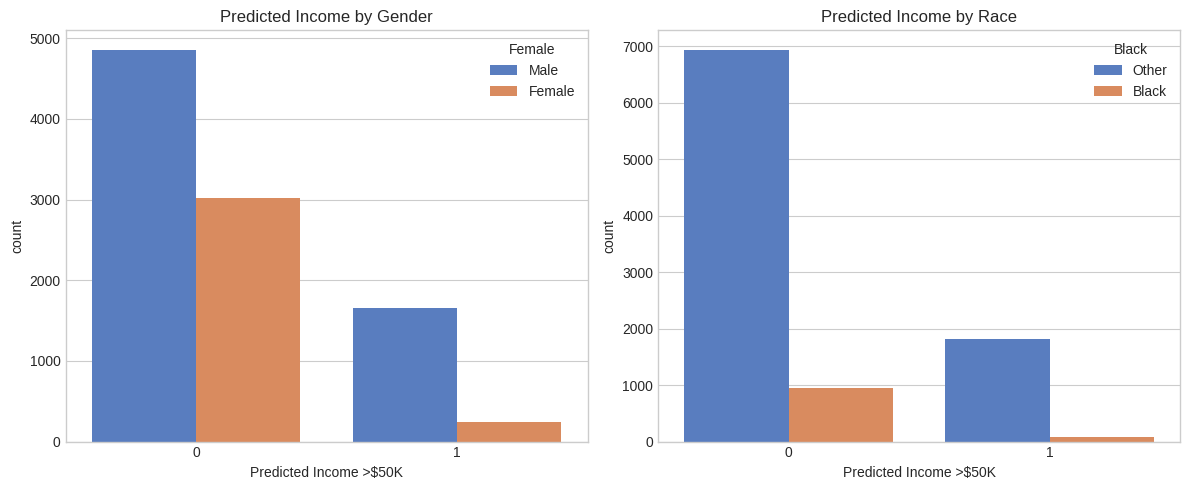

In [21]:
## Visualize Bias in Predictions# Visualize prediction distributions by gender
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_pred, hue=gender_test)
plt.title('Predicted Income by Gender')
plt.xlabel('Predicted Income >$50K')
plt.legend(title='Female', labels=['Male', 'Female'])

# Visualize prediction distributions by race
plt.subplot(1, 2, 2)
sns.countplot(x=y_pred, hue=race_test)
plt.title('Predicted Income by Race')
plt.xlabel('Predicted Income >$50K')
plt.legend(title='Black', labels=['Other', 'Black'])

plt.tight_layout()
plt.show()

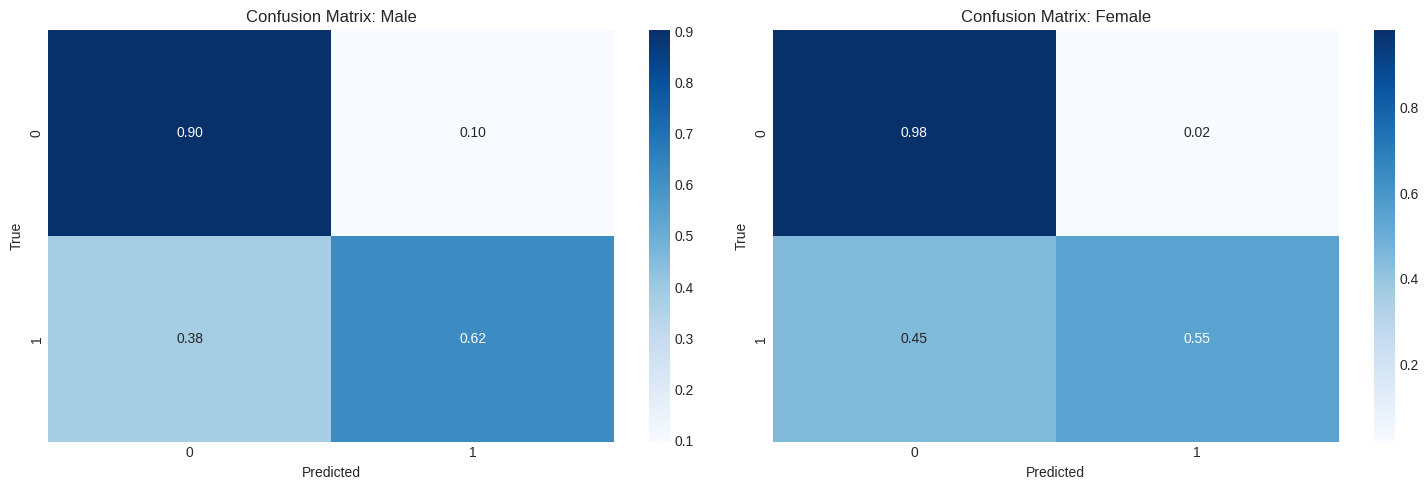

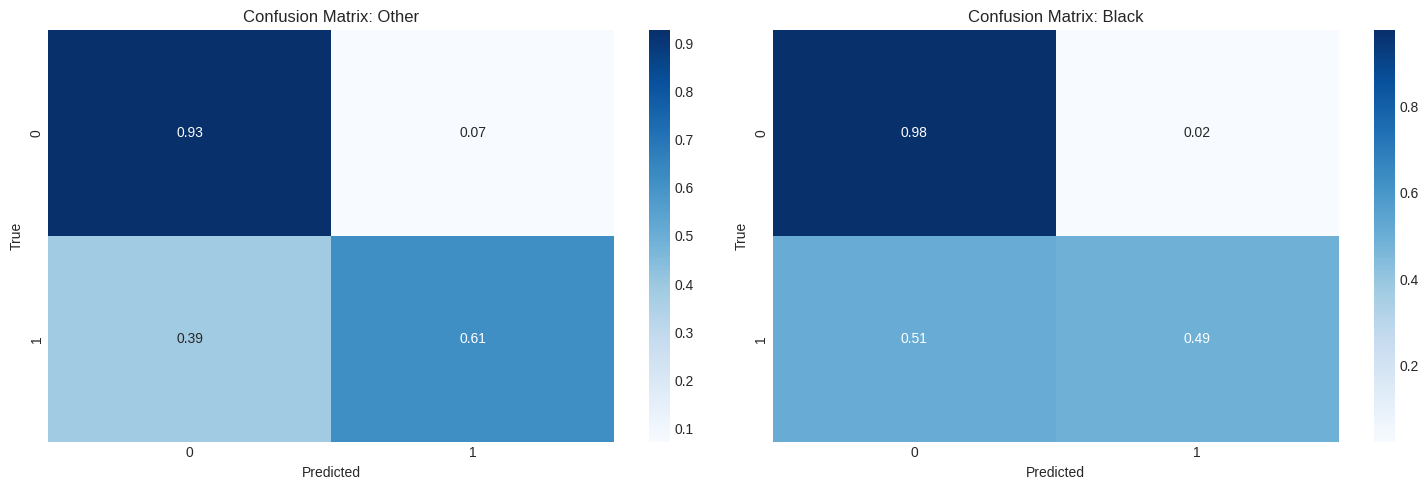

In [22]:
# Create a confusion matrix for each group
def plot_confusion_matrices(y_true, y_pred, protected_attribute, group_names):
    fig, axes = plt.subplots(1, len(group_names), figsize=(15, 5))

    for i, name in enumerate(group_names):
        if i == 0:
            idx = ~protected_attribute
        else:
            idx = protected_attribute

        cm = confusion_matrix(y_true[idx], y_pred[idx], normalize='true')
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Confusion Matrix: {name}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')

    plt.tight_layout()
    plt.show()

# Plot confusion matrices by gender
plot_confusion_matrices(y_test, y_pred, gender_test, ['Male', 'Female'])

# Plot confusion matrices by race
plot_confusion_matrices(y_test, y_pred, race_test, ['Other', 'Black'])

In [23]:
# Part 3: Bias Mitigation Techniques

In [24]:

#Now that we've identified bias in our model, let's implement techniques to mitigate it.

## 1. Pre-processing Techniques

### A. Reweighing

In [25]:


## 2. In-Processing Techniques

### Constrained Learning

In [26]:
# Convert to AIF360 dataset format
privileged_groups = [{'sex': 0}]  # Male
unprivileged_groups = [{'sex': 1}]  # Female

# Create a dataset with features and protected attributes
X_train_with_protected = X_train.copy()
X_train_with_protected['sex'] = gender_train.astype(int)

In [27]:
# Create the dataset
aif_train = BinaryLabelDataset(
    df=pd.concat([X_train_with_protected, pd.Series(y_train, name='income')], axis=1),
    label_names=['income'],
    protected_attribute_names=['sex'],
    favorable_label=1,
    unfavorable_label=0
)

In [28]:
# Apply reweighing
rw = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
aif_train_transformed = rw.fit_transform(aif_train)

# Get the transformed dataset and weights
# dataset_transformed = aif_train_transformed.convert_to_dataframe()[0]  # Incorrect: This doesn't include weights
weights = aif_train_transformed.instance_weights  # Correct: Access instance weights directly
features = aif_train_transformed.features  # Correct: Access features directly

# Train a model with the weights
model_rw = LogisticRegression(max_iter=1000, random_state=42)
model_rw.fit(features, aif_train_transformed.labels.ravel(), sample_weight=weights) # Correct: Use ravel() for labels

LogisticRegression(max_iter=1000, random_state=42)

In [29]:
# Prepare test data
X_test_for_pred = X_test.copy()
#X_test_for_pred.drop('sex', axis=1, inplace=True, errors='ignore') # Removing this line to retain the 'sex' column in the test data for prediction. The column should be present during prediction as it was present during training.
X_test_for_pred['sex'] = gender_test.astype(int) # Adding the column 'sex' if it was not already created to match the training data.
# Make predictions
y_pred_rw = model_rw.predict(X_test_for_pred)

# Evaluate overall model performance
print("Overall model accuracy (Reweighing):", accuracy_score(y_test, y_pred_rw))

# Evaluate fairness
print("\nFairness Metrics (Reweighing):")
print("Demographic Parity Difference (Gender):",
      demographic_parity_difference(y_true=y_test,
                                   y_pred=y_pred_rw,
                                   sensitive_features=gender_test))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Overall model accuracy (Reweighing): 0.8509571092230526

Fairness Metrics (Reweighing):
Demographic Parity Difference (Gender): 0.08871472077427829


In [30]:
## 2. In-Processing Techniques

### Constrained Learning

In [31]:
# Apply ExponentiatedGradient for demographic parity
constraint = DemographicParity()
mitigator = ExponentiatedGradient(
    estimator=LogisticRegression(max_iter=1000), # Changed: Added estimator=
    constraints=constraint,
    eps=0.01,
    max_iter=50
    # Removed: random_state=42  ExponentiatedGradient does not have this parameter
)

# Fit the mitigator
mitigator.fit(X_train, y_train, sensitive_features=gender_train)

# Get predictions
y_pred_in = mitigator.predict(X_test)

# Evaluate overall model performance
print("Overall model accuracy (In-processing):", accuracy_score(y_test, y_pred_in))

# Evaluate fairness
print("\nFairness Metrics (In-processing):")
print("Demographic Parity Difference (Gender):",
      demographic_parity_difference(y_true=y_test,
                                   y_pred=y_pred_in,
                                   sensitive_features=gender_test))

Overall model accuracy (In-processing): 0.8407206469444161

Fairness Metrics (In-processing):
Demographic Parity Difference (Gender): 0.02238809347433851


In [32]:
## 3. Post-Processing Techniques

### Threshold Adjustment

In [33]:
# Function to adjust thresholds by group
def threshold_adjustment(probabilities, protected_attribute, thresholds):
    adjusted_predictions = np.zeros_like(probabilities, dtype=int)

    # For each group, apply the appropriate threshold
    for group_idx, threshold in enumerate(thresholds):
        if group_idx == 0:
            mask = ~protected_attribute  # Privileged group
        else:
            mask = protected_attribute   # Unprivileged group

        adjusted_predictions[mask] = (probabilities[mask] >= threshold).astype(int)

    return adjusted_predictions

# Get probability predictions from the original model
y_prob = model.predict_proba(X_test)[:, 1]

# Find optimal thresholds for demographic parity
def find_thresholds_for_demographic_parity(y_prob, sensitive_feature):
    privileged_mask = ~sensitive_feature
    unprivileged_mask = sensitive_feature

    privileged_probs = y_prob[privileged_mask]
    unprivileged_probs = y_prob[unprivileged_mask]

    best_dpd = float('inf')
    best_thresholds = [0.5, 0.5]

    # Try different threshold combinations
    for p_threshold in np.arange(0.3, 0.7, 0.01):
        for u_threshold in np.arange(0.3, 0.7, 0.01):
            p_pred = (privileged_probs >= p_threshold).astype(int)
            u_pred = (unprivileged_probs >= u_threshold).astype(int)

            p_selection_rate = p_pred.mean()
            u_selection_rate = u_pred.mean()

            dpd = abs(p_selection_rate - u_selection_rate)

            if dpd < best_dpd:
                best_dpd = dpd
                best_thresholds = [p_threshold, u_threshold]

    return best_thresholds

# Find optimal thresholds
optimal_thresholds = find_thresholds_for_demographic_parity(y_prob, gender_test)
print("Optimal thresholds (Male, Female):", optimal_thresholds)

# Apply threshold adjustment
y_pred_post = threshold_adjustment(y_prob, gender_test, optimal_thresholds)

# Evaluate overall model performance
print("Overall model accuracy (Post-processing):", accuracy_score(y_test, y_pred_post))

# Evaluate fairness
print("\nFairness Metrics (Post-processing):")
print("Demographic Parity Difference (Gender):",
      demographic_parity_difference(y_true=y_test,
                                   y_pred=y_pred_post,
                                   sensitive_features=gender_test))

Optimal thresholds (Male, Female): [np.float64(0.6900000000000004), np.float64(0.3)]
Overall model accuracy (Post-processing): 0.8426655747773569

Fairness Metrics (Post-processing):
Demographic Parity Difference (Gender): 0.03142186821018478


In [34]:
## Compare Mitigation Techniques

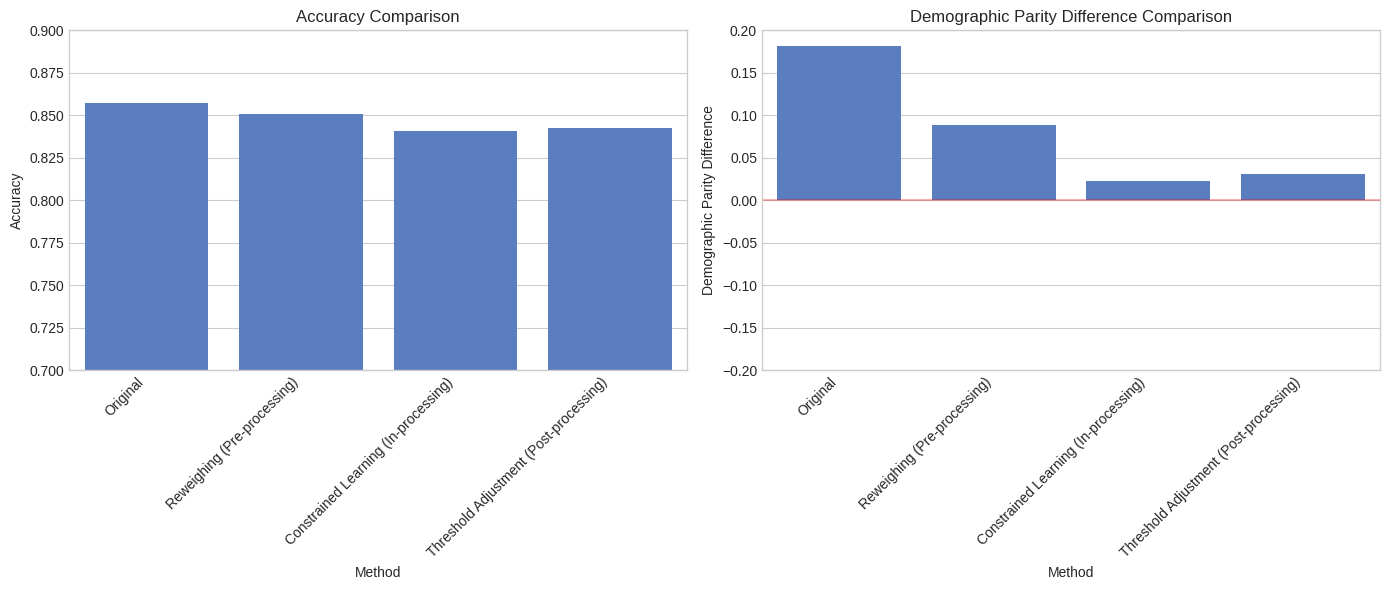

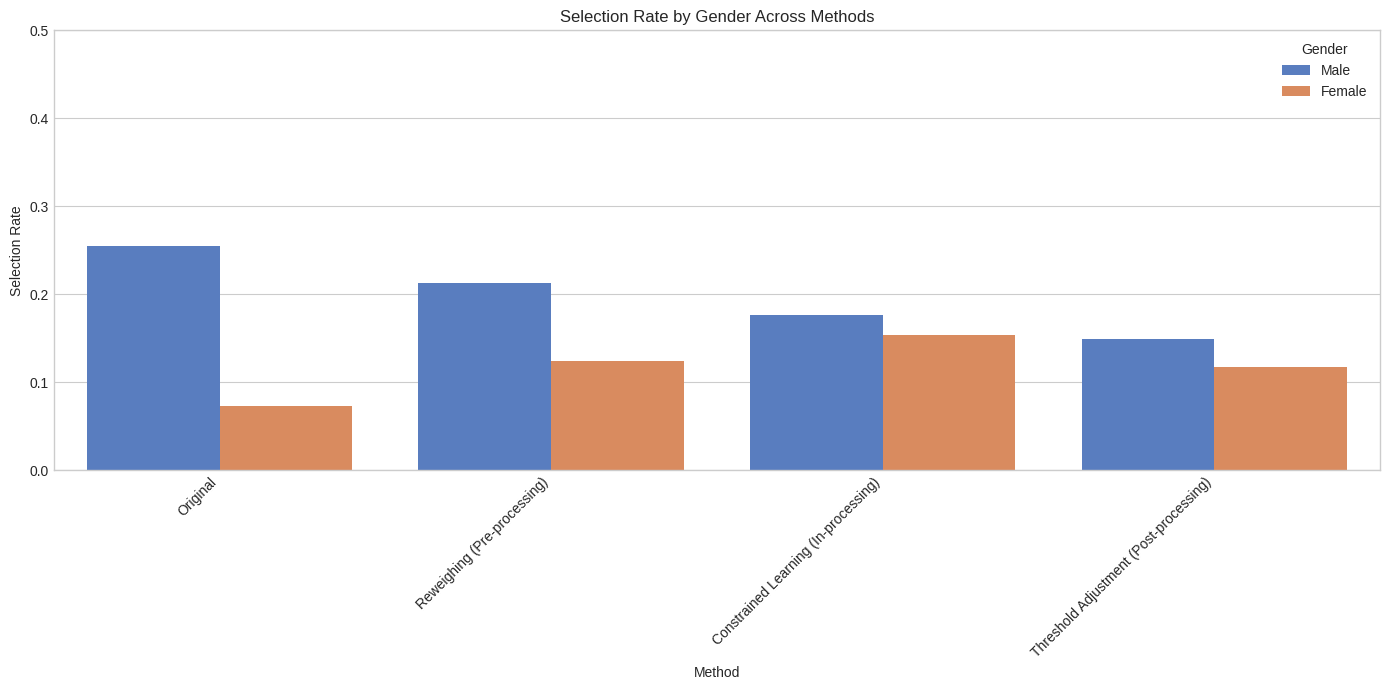

In [35]:
# Compare all approaches
comparison_data = {
    'Original': y_pred,
    'Reweighing (Pre-processing)': y_pred_rw,
    'Constrained Learning (In-processing)': y_pred_in,
    'Threshold Adjustment (Post-processing)': y_pred_post
}

# Calculate accuracy for each approach
accuracy_results = {name: accuracy_score(y_test, preds) for name, preds in comparison_data.items()}

# Calculate demographic parity difference for each approach
dpd_results = {name: demographic_parity_difference(y_true=y_test,
                                                 y_pred=preds,
                                                 sensitive_features=gender_test)
              for name, preds in comparison_data.items()}

# Create a comparison dataframe
comparison_df = pd.DataFrame({
    'Accuracy': accuracy_results,
    'Demographic Parity Difference': dpd_results
})

comparison_df.index.name = 'Method'
comparison_df.reset_index(inplace=True)

# Plot comparison
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Method', y='Accuracy', data=comparison_df)
plt.title('Accuracy Comparison')
plt.ylim(0.7, 0.9)  # Adjust based on your results
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
sns.barplot(x='Method', y='Demographic Parity Difference', data=comparison_df)
plt.title('Demographic Parity Difference Comparison')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.ylim(-0.2, 0.2)  # Adjust based on your results
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()



# Calculate and compare selection rates by group for each method
def calculate_selection_rates(predictions, protected_attribute):
    privileged_mask = ~protected_attribute
    unprivileged_mask = protected_attribute

    privileged_rate = predictions[privileged_mask].mean()
    unprivileged_rate = predictions[unprivileged_mask].mean()

    return privileged_rate, unprivileged_rate

# Calculate selection rates for each method
selection_rates = {}
for name, preds in comparison_data.items():
    privileged_rate, unprivileged_rate = calculate_selection_rates(preds, gender_test)
    selection_rates[name] = {'Male': privileged_rate, 'Female': unprivileged_rate}

# Create dataframe for visualization
selection_df = pd.DataFrame(selection_rates).reset_index()
selection_df = selection_df.melt(id_vars='index', var_name='Method', value_name='Selection Rate')
selection_df.rename(columns={'index': 'Gender'}, inplace=True)

# Plot selection rates
plt.figure(figsize=(14, 7))
sns.barplot(x='Method', y='Selection Rate', hue='Gender', data=selection_df)
plt.title('Selection Rate by Gender Across Methods')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender')
plt.ylim(0, 0.5)  # Adjust based on your results
plt.tight_layout()
plt.show()

In [36]:
# Part 4: Decision Maker's Guide to Fair AI

#Based on your analysis in this lab, create a comprehensive guide for project managers and decision makers to address bias in AI systems. Include the following components:

## 1. Bias Risk Assessment Checklist

#Create a checklist for identifying potential bias risks in AI projects.
#*Your answer here:*

## 2. Decision Framework for Bias Mitigation

#Develop a framework to help decision makers select appropriate bias mitigation strategies.
#*Your answer here:*

## 3. Monitoring Plan Template

#Design a monitoring plan to continuously evaluate AI systems for emerging biases.
#*Your answer here:*

## 4. Organizational Policies and Practices

#Recommend organizational policies to support fair AI implementation.
#*Your answer here:*

## 5. Communication Strategies

#Suggest strategies for effectively communicating with technical teams about bias concerns.
#*Your answer here:*

# Reflection and Conclusion

#1. What surprised you most about the bias detection and mitigation process?
#2. What challenges might you face when implementing these approaches in a real-world setting?
#3. How would you prioritize fairness against other business objectives when deploying AI solutions?

#*Your answers here:*

# AI Usage Documentation

#If you used generative AI tools to help complete this lab, please document your usage below:

#| **How Generative AI was Used** | **Tool Used (Chat GPT, Google Gemini, etc.)** | **How you edited the Generative AI output, if at all** | **Generative AI Conversation Link with Iterations, if available** |
#|-------------------|----------------|------------------------|------------------------|
#| | | | |
#| | | | |

# References

#1. Mehrabi, N., Morstatter, F., Saxena, N., Lerman, K., & Galstyan, A. (2021). A survey on bias and fairness in machine learning. ACM Computing Surveys.
#2. Holstein, K., Wortman Vaughan, J., Daumé III, H., Dudik, M., & Wallach, H. (2019). Improving fairness in machine learning systems: What do industry practitioners need?
#3. IBM AI Fairness 360 Documentation: https://aif360.mybluemix.net/
#4. Fairlearn Documentation: https://fairlearn.org/